Aleksandra Bednarczuk

References:
* *Recommenders System* course materials by professor Santiago Segui (https://github.com/ssegui/recsysMaster2020)
* Badrul Sarwar, George Karypis, Joseph Konstan, John Riedl, *Item-based Collaborative Filtering Recommendation Algorithms*, 2001 (https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.167.7612)
* Paolo Cremonesi, Yehuda Koren, Roberto Turrin, *Performance of Recommender Algorithms on Top-N Recommendation Tasks*, 2010 (https://dl.acm.org/doi/pdf/10.1145/1864708.1864721)
* https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea
* https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_KNN.ipynb

# Movie recommender system

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from fuzzywuzzy import fuzz
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import norm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import scipy.sparse
from sklearn.utils.extmath import randomized_svd

C:\Users\THINK\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


01_MovieRec_EDA.ipynb:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  "cells": [
01_MovieRec_EDA.ipynb:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  "metadata": {},
01_MovieRec_EDA.ipynb:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ]


Shape of the original ratings dataset: (1000209, 3)
There are 6040 unique users and 3706 unique movies in this data set
Movies were rated from 1 to 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
user_id     1000209 non-null int64
movie_id    1000209 non-null int64
rating      1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB


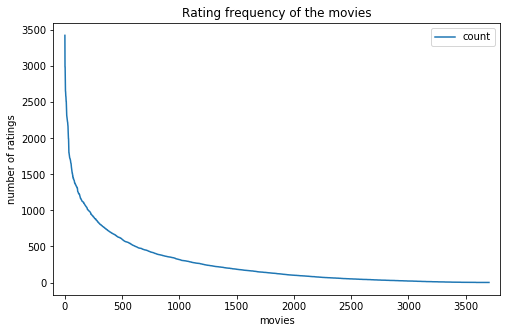

Number of movies in the original ratings data:  3706
Shape of the original ratings data:  (1000209, 3)
--
Number of movies after dropping unpopular movies:  2019
Shape of the dataset after dropping unpopular movies:  (942225, 3)


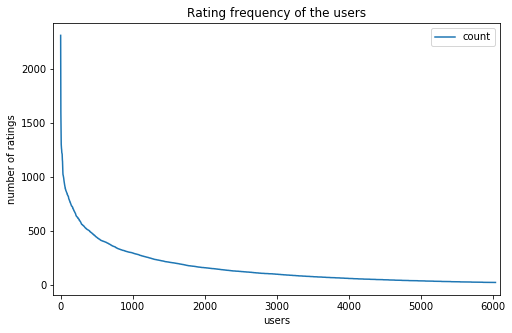

Number of users in the original ratings data:  6040
Shape of the original ratings data:  (1000209, 3)
--
Number of users after dropping inactive users:  4297
Shape of the dataset after dropping unpopular movies and inactive users:  (887961, 3)


In [2]:
%run 01_MovieRec_EDA.ipynb

In [3]:
ind_to_movie = {}
for index, row in movies.iterrows():
    ind_to_movie[row['movie_id']] = row['title']

In [4]:
## Small dataset to make the computations faster
def smaller_data(df, test_size = 0.4):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * test_size)),
                                   replace=False)
    df.loc[sampled_ids, 'small'] = True
    return df

## Divide the data in two sets: training and test
def assign_to_set(df, test_size = 0.33):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * test_size)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [5]:
data.shape

(887961, 3)

In [6]:
dataSmall = data[data['movie_id']<2000]
print(dataSmall.shape)

dataSmall.loc[:,'for_testing'] = False
grouped = dataSmall.groupby('movie_id', group_keys=False).apply(assign_to_set)
dataSmall_train = dataSmall[grouped.for_testing == False]
dataSmall_test = dataSmall[grouped.for_testing == True]

print(dataSmall_train.shape )
print(dataSmall_test.shape )

print('Number of users:', dataSmall.user_id.nunique() )
print('Number of movies:',dataSmall.movie_id.nunique() )

print('Number of users in train set:', dataSmall_train.user_id.nunique() )
print('Number of movies in train set:',dataSmall_train.movie_id.nunique() )

print('Number of users in test set:', dataSmall_test.user_id.nunique() )
print('Number of movies in test set:',dataSmall_test.movie_id.nunique() )

(484948, 3)


C:\Users\THINK\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\THINK\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(324426, 4)
(160522, 4)
Number of users: 4296
Number of movies: 1004
Number of users in train set: 4296
Number of movies in train set: 1004
Number of users in test set: 4291
Number of movies in test set: 1004


## 1. Item-Based Recommender System

* Adjusted cosine similarity

(based on the definition of cosine distance (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cosine.html) and the fact that cosine_similarity = 1 - cosine_distance (https://stackoverflow.com/questions/58381092/difference-between-cosine-similarity-and-cosine-distance).

In [7]:
from scipy.spatial import distance

def SimAdjCos(data, movie1, movie2, min_common_items=1):
    users1 = data[data['movie_id'] == movie1]
    users2 = data[data['movie_id'] == movie2]
    df = pd.merge(users1, users2, on='user_id')
    df2 = pd.merge(df, pd.DataFrame(data.groupby('user_id').rating.mean()).rename(columns={'rating': 'user_mean'}), 
                   on='user_id')
    if len(df)<2:
        return 0    
    if(len(df)<min_common_items):
        return 0   
    #sim = distance.cosine(df['rating_x'], df['rating_y'])
    sim = 1 - distance.cosine(df2['rating_x'] - df2['user_mean'], df['rating_y'] - df2['user_mean'])
    if(np.isnan(sim)):
        return 0
    return sim

* The code below is based on the code provided by professor Santiago Segui, but modified to apply to item-item recommendation methodology using adjusted cosine similarity.

In [8]:
class ItemCF:
   
    def __init__(self, data, similarity = SimAdjCos):
        self.data = data
        self.sim_method=similarity
        self.user_item = data.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)
        self.sim_matrix = pd.DataFrame(np.sum([0]),columns=dataSmall_train.movie_id.unique(), index=dataSmall_train.movie_id.unique())
        
    def learn(self):
        all_movies=set(self.data['movie_id'])
        self.sim_matrix = {}
        for movie1 in all_movies:
            self.sim_matrix.setdefault(movie1, {})
            a=dataSmall_train[dataSmall_train['movie_id']==movie1][['user_id']]
            data_reduced=pd.merge(dataSmall_train,a,on='user_id')
            for movie2 in all_movies:
                #print(movie1, movie2)
                if movie1==movie2: 
                    continue
                self.sim_matrix.setdefault(movie2, {})
                if(movie1 in self.sim_matrix[movie2]):
                    continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,movie1,movie2)
                if(sim<0):
                    self.sim_matrix[movie1][movie2]=0
                    self.sim_matrix[movie2][movie1]=0
                else:
                    self.sim_matrix[movie1][movie2]=sim
                    self.sim_matrix[movie2][movie1]=sim
            
    def estimated_rating(self, user_id, movie_id):
        rating_num = 0.0
        rating_den = 0.0
        if self.user_item[movie_id][user_id] != 0:
            return print('User {0} has already seen "{1}" (rating: {2})'.format(user_id, ind_to_movie[movie_id], self.user_item[movie_id][user_id]))
        else:
            user_movies = list(self.data[self.data['user_id'] == user_id].movie_id)
        for movie in user_movies:
            if movie_id==movie: continue 
            rating_num += self.sim_matrix[movie][movie_id] * self.user_item[movie][user_id]
            rating_den += self.sim_matrix[movie][movie_id]
        if rating_den==0: 
            if self.data.rating[self.data['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.data.rating[self.data['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.data.rating[self.data['user_id']==user_id].mean()
        return print('Estimated rating for "{0}" is {1}'.format(ind_to_movie[movie_id], round(rating_num/rating_den,2))) 

    def estimate(self, user_id, movie_id):
        rating_num = 0.0
        rating_den = 0.0
        user_movies = list(self.data[self.data['user_id'] == user_id].movie_id)
        for movie in user_movies:
            if movie_id==movie: continue 
            rating_num += self.sim_matrix[movie][movie_id] * self.user_item[movie][user_id]
            rating_den += self.sim_matrix[movie][movie_id]
        if rating_den==0: 
            if self.data.rating[self.data['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.data.rating[self.data['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.data.rating[self.data['user_id']==user_id].mean()
        return round(rating_num/rating_den,2)


In [9]:
RecSys = ItemCF(dataSmall_train)

In [10]:
%time RecSys.learn()

Wall time: 1h 10min 51s


In [11]:
RecSys.estimate(2,19)

3.19

## 2. Factorization Recommender System

* Pure SVD method was one of the methods used in Paolo Cremonesi, Yehuda Koren, Roberto Turrin, *Performance of Recommender Algorithms on Top-N Recommendation Tasks*, 2010 (https://dl.acm.org/doi/pdf/10.1145/1864708.1864721)
* Code used below is a modified code from: https://github.com/mesuvash/pyrec/blob/master/pyrec/recommender/bilinear_models/pureSVD.py

In [12]:
class PureSVD:

    def __init__(self, data, n = 150):
        self.data = data
        self.nfactor = n
        self.U = None
        self.Q = None

    def learn(self):
        self.user_item = self.data.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)
        
        user_index = np.arange(len(self.user_item.index))
        self.users = dict(zip(user_index,self.user_item.index ))
        self.users_index2id = dict(zip(self.user_item.index,user_index)) 
        
        movie_index = np.arange(len(self.user_item.columns))
        self.movies = dict(zip(movie_index,self.user_item.columns ))   
        self.movies_index2id = dict(zip(self.user_item.columns, movie_index))
        
        U, sigma, QT = randomized_svd(np.array(self.user_item), self.nfactor)
        sigma = scipy.sparse.diags(sigma, 0)
        self.U = U * sigma
        self.Q = QT.T
        
    def estimate_all(self):
        self.r = np.dot(self.U, self.Q.T)
        return self.r

    def estimate(self, user_id, movie_id):
        u = self.users_index2id[user_id]
        i = self.movies_index2id[movie_id]
        prediction =  np.dot(self.U[u, :], self.Q[i, :].T)
        return prediction

In [13]:
RecSysSVD = PureSVD(dataSmall_train)

In [14]:
%time RecSysSVD.learn()

Wall time: 571 ms


In [15]:
RecSysSVD.estimate(2,19)

-0.05509781784763231

## 3. Evaluate

* Function for calculating precision & recall based on the strategy from: Paolo Cremonesi, Yehuda Koren, Roberto Turrin, *Performance of Recommender Algorithms on Top-N Recommendation Tasks*, 2010 (https://dl.acm.org/doi/pdf/10.1145/1864708.1864721)

In [16]:
## Divide the data in two sets: training and test
def assign_to_set2(df, test_size = 0.014):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * test_size)),
                                   replace=False)
    df.loc[sampled_ids, 'for_evaluation'] = True
    return df

In [17]:
dataSmall_test.loc[:,'for_evaluation'] = False
grouped2 = dataSmall_test.groupby('movie_id', group_keys=False).apply(assign_to_set2)
dataSmall_test_probe = dataSmall_test[grouped2.for_evaluation == True]

In [18]:
def precision_recall(model, data_test, unseen_size = 100, top_n = 20):
    test_set = data_test[data_test['rating'] == 5.0]
    T = len(test_set)
    hits = 0.0
    for row in range(T):
        u = test_set.iloc[row].user_id
        i = test_set.iloc[row].movie_id
        unseen = (np.random.choice(data_test[data_test['user_id'] != u].movie_id,
                                   size = unseen_size,
                                   replace = False)).tolist()
        unseen.append(i)
        ranking = {}
        for movie in unseen:
            ranking[movie] = model.estimate(u, movie)
        ranking_order = {k: v for k, v in sorted(ranking.items(), key=lambda item: item[1])}
        if list(ranking_order.keys()).index(i) < top_n:
            hits += 1
    precision_recall.recall = hits/T
    precision_recall.precision = precision_recall.recall/top_n
    return print('Precision: {0}, Recall: {1}'.format(precision_recall.precision, precision_recall.recall))

* Evaluation of ItemCF

In [19]:
precision_recall(RecSys, dataSmall_test_probe)

Precision: 0.0020771513353115725, Recall: 0.04154302670623145


In [20]:
t = 100
precision_list = []
recall_list = []
for n in range(10, t+10, 10):
    print('Top %s movies' %n)
    precision_recall(RecSys, dataSmall_test_probe, t, n)
    precision_list.append(precision_recall.precision)
    recall_list.append(precision_recall.recall)

Top 10 movies
Precision: 0.0019287833827893175, Recall: 0.019287833827893175
Top 20 movies
Precision: 0.0020771513353115725, Recall: 0.04154302670623145
Top 30 movies
Precision: 0.002818991097922849, Recall: 0.08456973293768547
Top 40 movies
Precision: 0.003820474777448071, Recall: 0.15281899109792285
Top 50 movies
Precision: 0.004807121661721068, Recall: 0.2403560830860534
Top 60 movies
Precision: 0.005712166172106825, Recall: 0.3427299703264095
Top 70 movies
Precision: 0.006803730394234845, Recall: 0.4762611275964392
Top 80 movies
Precision: 0.008271513353115727, Recall: 0.6617210682492581
Top 90 movies
Precision: 0.009891196834817012, Recall: 0.8902077151335311
Top 100 movies
Precision: 0.01, Recall: 1.0


In [21]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [22]:
def evaluate(estimate_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([estimate_f(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

In [23]:
print('RMSE for Item-based Recommender System: %s' % evaluate(RecSys.estimate,dataSmall_train,dataSmall_test))

RMSE for Item-based Recommender System: 1.174667525052358


* Evaluation of PureSVD

In [24]:
precision_recall(RecSysSVD, dataSmall_test_probe)

Precision: 0.00771513353115727, Recall: 0.1543026706231454


In [25]:
t = 100
precision_list = []
recall_list = []
for n in range(10, t+10, 10):
    print('Top %s movies' %n)
    precision_recall(RecSysSVD, dataSmall_test_probe, t, n)
    precision_list.append(precision_recall.precision)
    recall_list.append(precision_recall.recall)

Top 10 movies
Precision: 0.007863501483679525, Recall: 0.07863501483679525
Top 20 movies
Precision: 0.007047477744807122, Recall: 0.14094955489614244
Top 30 movies
Precision: 0.0068743818001978235, Recall: 0.2062314540059347
Top 40 movies
Precision: 0.006899109792284866, Recall: 0.27596439169139464
Top 50 movies
Precision: 0.007299703264094955, Recall: 0.3649851632047478
Top 60 movies
Precision: 0.007987141444114738, Recall: 0.4792284866468843
Top 70 movies
Precision: 0.008965663416701991, Recall: 0.6275964391691394
Top 80 movies
Precision: 0.01016320474777448, Recall: 0.8130563798219584
Top 90 movies
Precision: 0.010698977909660403, Recall: 0.9629080118694362
Top 100 movies
Precision: 0.01, Recall: 1.0


In [26]:
print('RMSE for PureSVD: %s' % evaluate(RecSysSVD.estimate,dataSmall_train,dataSmall_test))

RMSE for PureSVD: 2.2237150637301166
